# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [24]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [25]:
# Use this space for any additional import statements you need
import numpy as np
from matplotlib import pyplot as plt



In [27]:
# Some punctuation variations
punctuation = set(punctuation)  # speeds up comparison
tw_punct = punctuation - {"#"}  # For Twitter, keep hashtags

# Stopwords
sw = set(stopwords.words("english"))

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# Full set of emojis
all_language_emojis = set()
for country in emoji.EMOJI_DATA:
    for em in emoji.EMOJI_DATA[country]:
        all_language_emojis.add(em)

def descriptive_stats(tokens, num_tokens=5, verbose=True):
    """
    Given a list of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity, and num_tokens most common tokens.
    Return a dictionary of these stats.
    """
    num_total = len(tokens)
    num_unique = len(set(tokens))
    num_chars = sum(len(t) for t in tokens)
    lex_div = num_unique / num_total if num_total > 0 else 0
    most_common = Counter(tokens).most_common(num_tokens)
    if verbose:
        print(f"Total tokens: {num_total}")
        print(f"Unique tokens: {num_unique}")
        print(f"Total characters: {num_chars}")
        print(f"Lexical diversity: {lex_div:.3f}")
        print(f"Most common tokens: {most_common}")
    return {
        "num_total": num_total,
        "num_unique": num_unique,
        "num_chars": num_chars,
        "lex_div": lex_div,
        "most_common": most_common
    }

def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return len(emojis) > 0

def remove_stop(tokens):
    # Remove stopwords from list of tokens
    return [t for t in tokens if t not in sw]

def remove_punctuation(text, punct_set=tw_punct):
    # Remove punctuation except hashtags (for Twitter)
    return "".join([ch for ch in text if ch not in punct_set])

def tokenize(text):
    # Split on whitespace, keep hashtags and emojis for Twitter
    if isinstance(text, list):
        text = " ".join(text)
    tokens = whitespace_pattern.split(str(text))
    # Remove empty tokens
    return [t for t in tokens if t]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [28]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/archa/Desktop/assignment 3/M1 Assignment Data (1)/M1 Results/"# change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [29]:
folder_path = r"C:/Users/archa/Desktop/assignment 3/M1 Assignment Data (1)/M1 Results/twitter"
print(os.listdir(folder_path))


['.DS_Store', 'cher_followers.txt', 'cher_followers_data.txt', 'robynkonichiwa_followers.txt', 'robynkonichiwa_followers_data.txt']


In [ ]:
def load_lyrics_from_folder(folder_path, artist_name):
    """
    Load lyrics text files from a folder into a DataFrame.
    Each file represents one song by the artist.
    """
    lyrics = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            lyrics.append({'artist': artist_name, 'lyrics': text})
    return pd.DataFrame(lyrics)

# Define lyrics folders
cher_lyrics_path = r"C:/Users/archa/Desktop/assignment 3/M1 Assignment Data (1)/M1 Results/lyrics/cher"
robyn_lyrics_path = r"C:/Users/archa/Desktop/assignment 3/M1 Assignment Data (1)/M1 Results/lyrics/robyn"

# Load and combine lyrics data
cher_lyrics_df = load_lyrics_from_folder(cher_lyrics_path, "cher")
robyn_lyrics_df = load_lyrics_from_folder(robyn_lyrics_path, "robyn")
lyrics_data = pd.concat([cher_lyrics_df, robyn_lyrics_df], ignore_index=True)


def load_twitter_from_file(file_path, artist_name):
    """
    Load a single .txt file of Twitter user descriptions into a DataFrame.
    Each line represents a user description.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        descriptions = file.readlines()
    return pd.DataFrame({
        'artist': artist_name,
        'description': [desc.strip() for desc in descriptions]
    })

# Define Twitter file paths
cher_twitter_path = r"C:/Users/archa/Desktop/assignment 3/M1 Assignment Data (1)/M1 Results/twitter/cher_followers_data.txt"
robyn_twitter_path = r"C:/Users/archa/Desktop/assignment 3/M1 Assignment Data (1)/M1 Results/twitter/robynkonichiwa_followers_data.txt"

# Load and combine twitter data
cher_twitter_df = load_twitter_from_file(cher_twitter_path, "cher")
robyn_twitter_df = load_twitter_from_file(robyn_twitter_path, "robyn")
twitter_data = pd.concat([cher_twitter_df, robyn_twitter_df], ignore_index=True)

## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [31]:
# Define the pipeline steps
my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

# Apply pipeline to lyrics
lyrics_data["tokens"] = lyrics_data["lyrics"].apply(lambda x: prepare(str(x), my_pipeline))
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len)

# Apply pipeline to twitter descriptions
twitter_data["tokens"] = twitter_data["description"].apply(lambda x: prepare(str(x), my_pipeline))
twitter_data["num_tokens"] = twitter_data["tokens"].map(len)




In [32]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [33]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
2936009,cher,"tykebrean\ttykebrean 🌿\t1473903343\tTulsa, OK\...","[tykebrean, tykebrean, 🌿, 1473903343, tulsa, o..."
4327588,robyn,reporterliz\tElizabeth Chou 🌊 🏖️ ☀️ 🌆 ⛰️\t3708...,"[reporterliz, elizabeth, chou, 🌊, 🏖️, ☀️, 🌆, ⛰..."
4012458,robyn,RitaTurkel\tjck🎧🎤\t815657986760863744\tFrankfu...,"[ritaturkel, jck🎧🎤, 815657986760863744, frankf..."
1131059,cher,RazorMebarak\tRazor87\t961560736039428096\tAca...,"[razormebarak, razor87, 961560736039428096, ac..."
771081,cher,christian_gagin\tchristopher\t1088100301473644...,"[christiangagin, christopher, 1088100301473644..."
138609,cher,"sweetjeyn\tJennie N.\t119356722\tQuezon City, ...","[sweetjeyn, jennie, n, 119356722, quezon, city..."
726931,cher,thereverendmari\tmariana\t289653374\tRS\t481\t...,"[thereverendmari, mariana, 289653374, rs, 481,..."
3801638,cher,Mai_Pavilonis\tMai Pavilonis\t149666792\t\t24\...,"[maipavilonis, mai, pavilonis, 149666792, 24, ..."
346138,cher,EmbryMeredith\tMeredithLeslie\t128274453409972...,"[embrymeredith, meredithleslie, 12827445340997..."
3078413,cher,jcbru\tJenny Bruerton\t30505286\t\t327\t479\t-...,"[jcbru, jenny, bruerton, 30505286, 327, 479, k..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One improvement would be to remove or split off tab-separated metadata in Twitter descriptions, such as IDs or locations. This would prevent noisy numeric tokens from entering the analysis and ensure cleaner, more meaningful tokenization that focuses on actual user-written text, improving word clouds and frequency results.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [34]:
# Combine all tokens for each artist's lyrics
cher_lyrics_tokens = lyrics_data[lyrics_data['artist'] == 'cher']["tokens"].explode().dropna().astype(str).tolist()
robyn_lyrics_tokens = lyrics_data[lyrics_data['artist'] == 'robyn']["tokens"].explode().dropna().astype(str).tolist()

print("Cher Lyrics Stats:")
cher_lyrics_stats = descriptive_stats(cher_lyrics_tokens)

print("\nRobyn Lyrics Stats:")
robyn_lyrics_stats = descriptive_stats(robyn_lyrics_tokens)

# Combine all tokens for each artist's Twitter
cher_twitter_tokens = twitter_data[twitter_data['artist'] == 'cher']["tokens"].explode().dropna().astype(str).tolist()
robyn_twitter_tokens = twitter_data[twitter_data['artist'] == 'robyn']["tokens"].explode().dropna().astype(str).tolist()

print("\nCher Twitter Stats:")
cher_twitter_stats = descriptive_stats(cher_twitter_tokens)

print("\nRobyn Twitter Stats:")
robyn_twitter_stats = descriptive_stats(robyn_twitter_tokens)



Cher Lyrics Stats:
Total tokens: 35916
Unique tokens: 3703
Total characters: 172634
Lexical diversity: 0.103
Most common tokens: [('love', 1004), ('im', 513), ('know', 486), ('dont', 440), ('youre', 333)]

Robyn Lyrics Stats:
Total tokens: 15227
Unique tokens: 2156
Total characters: 73787
Lexical diversity: 0.142
Most common tokens: [('know', 308), ('dont', 301), ('im', 299), ('love', 275), ('got', 251)]

Cher Twitter Stats:
Total tokens: 42408074
Unique tokens: 10713965
Total characters: 266883310
Lexical diversity: 0.253
Most common tokens: [('0', 334282), ('1', 281803), ('2', 237699), ('love', 220660), ('3', 196576)]

Robyn Twitter Stats:
Total tokens: 3888557
Unique tokens: 1143309
Total characters: 24138364
Lexical diversity: 0.294
Most common tokens: [('0', 31799), ('1', 23890), ('2', 17663), ('music', 15758), ('3', 14366)]


Q: what observations do you make about these data? 

A: Cher and Robyn lyrics have low lexical diversity, suggesting repetition in song vocabulary. Twitter data shows much higher diversity and volume, but is dominated by numeric tokens, indicating metadata noise. Robyn’s Twitter data shows slightly more diversity, and only Robyn’s includes meaningful tokens like “music” among top words.

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [35]:
# your code here
def top_unique_tokens(corpus_tokens, other_corpora_tokens, min_count=5, top_n=10):
    corpus_counter = Counter(corpus_tokens)
    other_counter = Counter(other_corpora_tokens)
    total_corpus = sum(corpus_counter.values())
    total_other = sum(other_counter.values())
    ratios = {}
    for token, count in corpus_counter.items():
        if count >= min_count:
            conc_corpus = count / total_corpus
            conc_other = other_counter[token] / total_other if token in other_counter else 1e-9
            ratio = conc_corpus / conc_other if conc_other > 0 else float('inf')
            ratios[token] = ratio
    top_tokens = sorted(ratios.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_tokens

# Unique tokens for each corpus
cher_lyrics_unique = top_unique_tokens(cher_lyrics_tokens, robyn_lyrics_tokens + cher_twitter_tokens + robyn_twitter_tokens)
robyn_lyrics_unique = top_unique_tokens(robyn_lyrics_tokens, cher_lyrics_tokens + cher_twitter_tokens + robyn_twitter_tokens)
cher_twitter_unique = top_unique_tokens(cher_twitter_tokens, cher_lyrics_tokens + robyn_lyrics_tokens + robyn_twitter_tokens)
robyn_twitter_unique = top_unique_tokens(robyn_twitter_tokens, cher_lyrics_tokens + robyn_lyrics_tokens + cher_twitter_tokens)

print("Top unique Cher lyrics tokens:", cher_lyrics_unique)
print("Top unique Robyn lyrics tokens:", robyn_lyrics_unique)
print("Top unique Cher Twitter tokens:", cher_twitter_unique)
print("Top unique Robyn Twitter tokens:", robyn_twitter_unique)


Top unique Cher lyrics tokens: [('geronimos', 194899.20926606524), ('repossessing', 194899.20926606524), ('alegrã\xada', 167056.46508519878), ('wontcha', 167056.46508519878), ('woahoh', 167056.46508519878), ('guilded', 6447.246074173071), ('milord', 5157.796859338457), ('ooga', 2722.1705646508517), ('gunman', 2578.8984296692283), ('achangin', 2578.8984296692283)]
Top unique Robyn lyrics tokens: [('headlessly', 722400.9982268339), ('bububurn', 525382.5441649702), ('câ\x80\x99mon', 525382.5441649702), ('aprã©ndelo', 525382.5441649702), ('tjaffs', 394036.90812372754), ('ultramagnetic', 328364.09010310634), ('yyou', 42599.04498588034), ('transistors', 24342.311420503054), ('toâ\x80¦', 18256.73356537729), ('ohho', 18256.73356537729)]
Top unique Cher Twitter tokens: [('resistor', 12686.263469545916), ('gramma', 10611.186916906436), ('#election2016', 7923.019564623472), ('🚫dms', 7498.572087947215), ('#dumptrump', 6295.970904031152), ('grandmom', 6060.166750322121), ('wifemother', 5352.7542891

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: Top unique tokens include slang, misspellings, and encoding artifacts (e.g., ca\x80\x90mon, alegrà\xada). Robyn Twitter tokens include Swedish words (förkärlek, hjälp), suggesting a multilingual audience. Cher Twitter tokens like #election2016 and #dumptrump highlight political themes. Some tokens reflect formatting noise, indicating a need for better text cleaning.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [36]:
print(lyrics_data.head())
print(twitter_data.head())


  artist                                             lyrics  \
0   cher  "88 Degrees"\n\n\n\nStuck in L.A., ain't got n...   
1   cher  "A Different Kind Of Love Song"\n\n\n\nWhat if...   
2   cher  "After All"\n\n\n\nWell, here we are again\nI ...   
3   cher  "Again"\n\n\n\nAgain evening finds me at your ...   
4   cher  "Alfie"\n\n\n\nWhat's it all about, Alfie?\nIs...   

                                              tokens  num_tokens  
0  [88, degrees, stuck, la, aint, got, friends, h...         182  
1  [different, kind, love, song, world, crazy, sa...         137  
2  [well, guess, must, fate, weve, tried, deep, i...         120  
3  [evening, finds, door, ask, could, try, dont, ...          34  
4  [alfie, whats, alfie, moment, live, whats, sor...          67  
  artist                                        description  \
0   cher  screen_name\tname\tid\tlocation\tfollowers_cou...   
1   cher       hsmcnp\tCountry Girl\t35152213\t\t1302\t1014   
2   cher  horrormomy\tJeny\t74

In [37]:
# Run this once at the top of your notebook
%matplotlib inline
# 1. Word Cloud Function
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
    """
    Generate and display a word cloud from word frequencies.
    """
    wc = WordCloud(
        width=800,
        height=400,
        background_color="black",
        colormap="Paired",
        max_font_size=150,
        max_words=max_words
    )

    # Convert to dict if Series
    if isinstance(word_freq, pd.Series):
        counter = word_freq.fillna(0).to_dict()
    else:
        counter = word_freq

    # Apply stopwords filter
    if stopwords:
        counter = {word: freq for word, freq in counter.items() if word not in stopwords}

    # Only plot if there's data
    if not counter:
        print(f"No data to plot for: {title}")
        return

    wc.generate_from_frequencies(counter)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    if title:
        plt.title(title)
    plt.axis("off")
    plt.show()

# 2. Word Frequency Count Function
def count_words(df, column='tokens', preprocess=None, min_freq=2):
    """
    Count word frequencies from a DataFrame column of token lists.
    """
    counter = Counter()

    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    df[column].map(update)

    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query("freq >= @min_freq")
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)


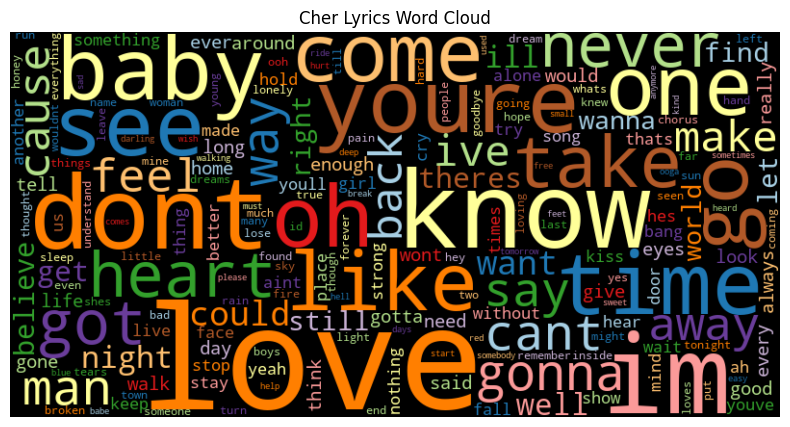

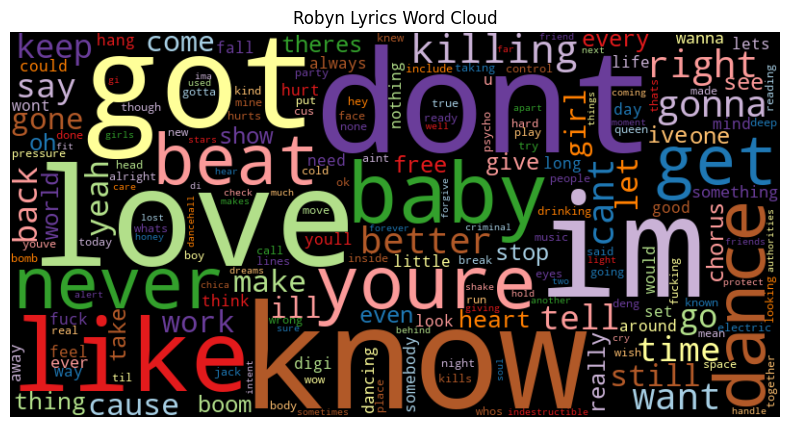

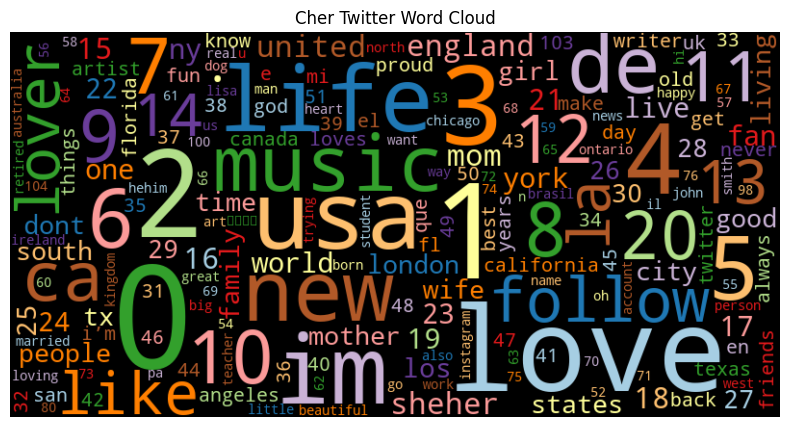

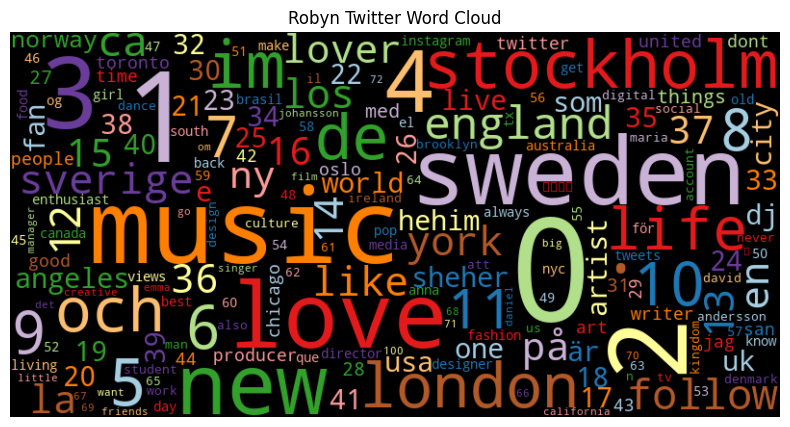

In [38]:
# 3. Subset by artist
cher_lyrics = lyrics_data[lyrics_data["artist"] == "cher"]
robyn_lyrics = lyrics_data[lyrics_data["artist"] == "robyn"]
cher_twitter = twitter_data[twitter_data["artist"] == "cher"]
robyn_twitter = twitter_data[twitter_data["artist"] == "robyn"]

# 4. Count word frequencies
cher_lyrics_freq = count_words(cher_lyrics, column="tokens", min_freq=2)
robyn_lyrics_freq = count_words(robyn_lyrics, column="tokens", min_freq=2)
cher_twitter_freq = count_words(cher_twitter, column="tokens", min_freq=2)
robyn_twitter_freq = count_words(robyn_twitter, column="tokens", min_freq=2)

# 5. Generate word clouds
wordcloud(cher_lyrics_freq["freq"], title="Cher Lyrics Word Cloud")
wordcloud(robyn_lyrics_freq["freq"], title="Robyn Lyrics Word Cloud")
wordcloud(cher_twitter_freq["freq"], title="Cher Twitter Word Cloud")
wordcloud(robyn_twitter_freq["freq"], title="Robyn Twitter Word Cloud")


Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: Cher and Robyn lyrics word clouds emphasize emotional themes like "love," "baby," "know," and "feel." Twitter clouds show strong geographic identity: "usa" and "california" for Cher, "sweden" and "stockholm" for Robyn. Robyn’s Twitter also includes Swedish words like “sverige” and “för,” suggesting a more international, multilingual fanbase presence.